# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-X @ weights))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # reg_term = (1 / (2 * self.C)) * np.linalg.norm(weights, ord=2)
        loss = np.mean(np.log(1 + np.exp(-(weights @ x.T) * y))) + (1 / (2 * self.C)) * np.linalg.norm(weights, ord=2)
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        self.losses = []
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            delta = - X_ext.T @ (y * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y)))) / len(y) + (self.weights_ / self.C)
            self.weights_ -= self.eta * delta
            self.losses.append(self.get_loss(X_ext, self.weights_, y))
            
            if np.linalg.norm(self.eta * delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [5]:
from sklearn import datasets
from sklearn import metrics

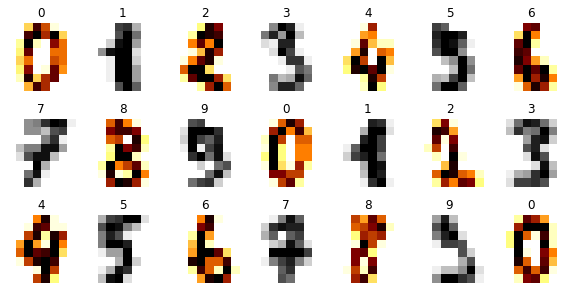

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


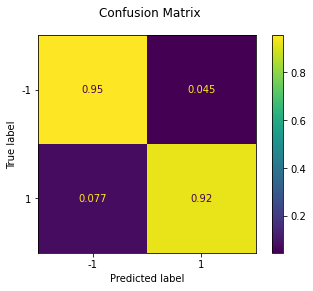

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

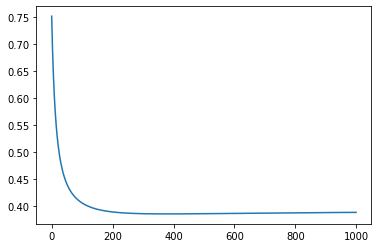

In [17]:
plt.plot(model.losses)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


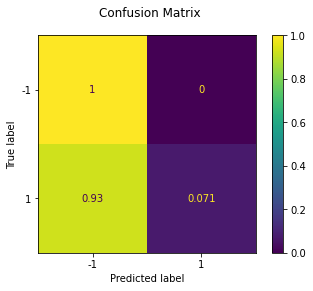

(0.5455810716771051, 0.5277777777777778)

In [18]:
model_01 = CustomLogisticRegression(eta=0.1)
train_acc, test_acc = fit_evaluate(model_01, X_train, y_train, X_test, y_test)
train_acc, test_acc

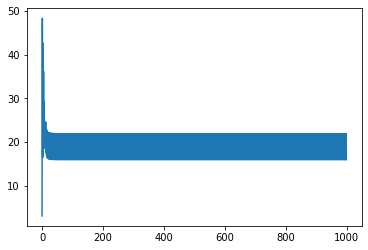

In [19]:
plt.plot(model_01.losses)

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


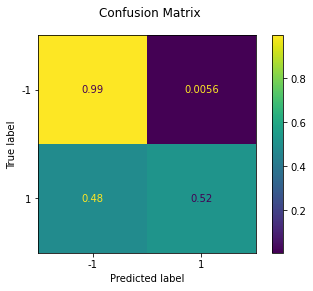

(0.7731384829505915, 0.7527777777777778)

In [20]:
model_001 = CustomLogisticRegression(eta=0.01)
train_acc, test_acc = fit_evaluate(model_001, X_train, y_train, X_test, y_test)
train_acc, test_acc

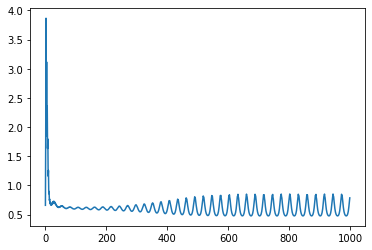

In [21]:
plt.plot(model_001.losses)

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


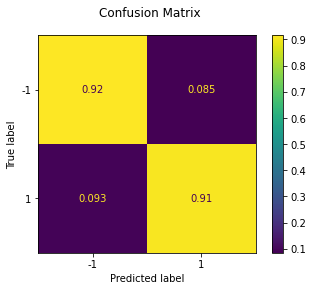

(0.8844815588030619, 0.9111111111111111)

In [22]:
model_00001 = CustomLogisticRegression(eta=0.0001)
train_acc, test_acc = fit_evaluate(model_00001, X_train, y_train, X_test, y_test)
train_acc, test_acc

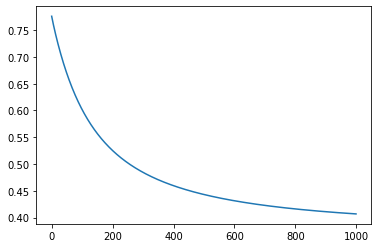

In [23]:
plt.plot(model_00001.losses)

As we can see. it's important to choose the right way. If we take a high value, maybe we can't reach the local min. If we take too small value, it takes a lot of time to reach min, and iterations won't be enough.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


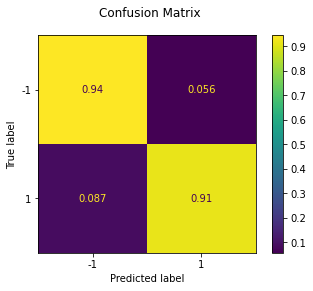

(0.9039665970772442, 0.9277777777777778)

In [24]:
model_С_05 = CustomLogisticRegression(C=0.5)
train_acc, test_acc = fit_evaluate(model_С_05, X_train, y_train, X_test, y_test)
train_acc, test_acc

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


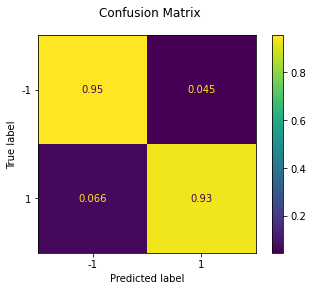

(0.9151009046624913, 0.9444444444444444)

In [25]:
model_С_5 = CustomLogisticRegression(C=5)
train_acc, test_acc = fit_evaluate(model_С_5, X_train, y_train, X_test, y_test)
train_acc, test_acc

Regularization keeps our model from overfitting. That why it's important to select a right value. In one way we can penalize too much. In the other way we can penalize not enough and we'll get overfitting. It needs some time to figure out imperically.

**(0.5 points)** Compare zero initialization and random initialization. 

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


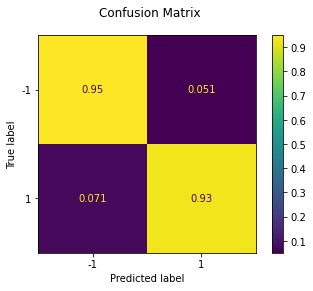

(0.9116214335421016, 0.9388888888888889)

In [26]:
lr_clf_zero = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(lr_clf_zero, X_train, y_train, X_test, y_test)
train_acc, test_acc

In [27]:
lr_clf_zero.weights_

array([ 1.04310940e-04,  0.00000000e+00, -5.54905037e-04,  2.59698049e-02,
        5.14078581e-02,  1.13535926e-02,  1.04123928e-01,  6.50144060e-02,
        2.57121147e-03, -5.43663088e-04, -1.74055835e-02, -7.40757034e-03,
        1.58116161e-02,  4.18275173e-02,  3.87602477e-02, -1.03719511e-03,
       -4.02284282e-03,  3.21521664e-04, -9.36839149e-03, -6.29624020e-02,
        2.07023252e-02,  4.94430827e-02, -3.86032058e-02, -4.55366520e-02,
       -6.36586729e-03,  6.51990598e-05, -3.96043595e-03,  8.39167159e-03,
        8.41760823e-02,  5.25506518e-02,  1.30273406e-02, -2.22873146e-02,
       -4.53806987e-04,  0.00000000e+00, -5.40181206e-02, -5.45243827e-04,
        4.30326696e-05, -1.77533157e-02,  4.35902036e-02,  2.40981332e-02,
        0.00000000e+00, -2.17014952e-04, -2.66055822e-02, -1.38754885e-01,
       -8.46903971e-02, -3.40933373e-03, -1.04603412e-03,  2.34003449e-02,
       -2.81876808e-03, -3.28157698e-04, -9.19506675e-03, -7.09473093e-02,
       -5.16738561e-03, -

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


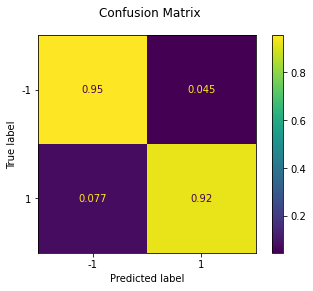

(0.9109255393180237, 0.9388888888888889)

In [28]:
lr_clf_nonzero = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate(lr_clf_nonzero, X_train, y_train, X_test, y_test)
train_acc, test_acc

In [29]:
lr_clf_nonzero.weights_

array([-5.61915300e-04,  2.54962444e-03,  8.05168031e-04,  2.64461817e-02,
        5.04182465e-02,  1.17457428e-02,  1.03371194e-01,  6.70463240e-02,
        3.05175128e-03,  6.58716972e-04, -1.89209111e-02, -5.64187669e-03,
        1.62034296e-02,  4.13576770e-02,  3.88461301e-02, -2.00441568e-03,
       -5.01388119e-03,  4.67910379e-04, -8.66514925e-03, -6.41268617e-02,
        2.05081900e-02,  4.95282731e-02, -3.86565158e-02, -4.52825268e-02,
       -6.46592187e-03,  1.68102605e-03, -5.05357780e-03,  8.64519669e-03,
        8.46281755e-02,  5.24000240e-02,  1.32485623e-02, -2.32947459e-02,
       -2.90703266e-03,  2.53927936e-03, -5.18311032e-02, -6.10504115e-04,
        6.59376294e-06, -1.81912986e-02,  4.38760219e-02,  2.39251629e-02,
       -2.13807403e-03, -2.44218976e-04, -2.90278222e-02, -1.38402384e-01,
       -8.51915438e-02, -2.81055457e-03, -1.37131401e-03,  2.29437756e-02,
       -2.55685254e-03, -2.11156633e-03, -7.06938258e-03, -7.12772594e-02,
       -4.66872991e-03, -

Usually, random initialization is better. But it's pretty hard to make great random initilization.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [30]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return np.sqrt((np.abs(np.expand_dims(X, 0) - np.expand_dims(Y, 1))**2).sum(axis=-1)).T
        # return np.sqrt(((X - Y)**2).sum(axis=1)).T
                
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        w = []
        for i in self.classes_:
            s = 0
            for j in range(len(y)):
                if y[j] == i:
                    s += weights[j]
            w.append(s)
        return w
            
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = []
            for p in P:
                distances = p.argsort()[:self.n_neighbors]
                labels = self.y[distances]
                if self.weights == 'distance':
                    weights_ = 1 / (p[distances] + self.eps)
                else:
                    weights_ = np.ones(labels.shape)
                count_labels = np.array(self.get_class_weights(labels, weights_))
                weights_of_points.append(count_labels / count_labels.sum())
                
            return np.array(weights_of_points)
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.predict_proba(X).argmax(axis=1)

In [31]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [32]:
model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]]))

array([[0.70710678, 1.41421356],
       [0.70710678, 1.        ]])

In [33]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [34]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

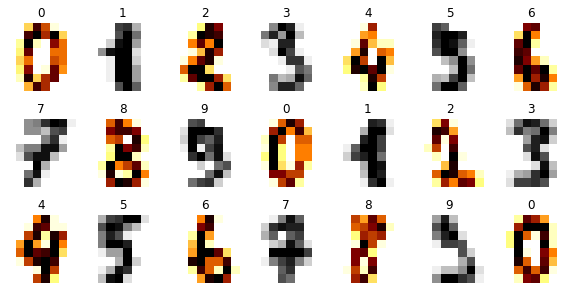

In [35]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [36]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [37]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


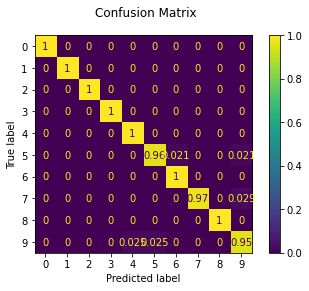

In [38]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [39]:
train_acc

1.0

In [40]:
test_acc

0.9861111111111112

In [41]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Errors:  
- 5 and 6  
- 5 and 9  
- 7 and 9  
- 4 and 9  
  
I think it's connected with numbers similarity

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

(array([  1.,   1.,   2.,   3.,   3.,   9.,   4.,   9.,  23., 305.]),
 array([0.32344832, 0.39110349, 0.45875866, 0.52641383, 0.59406899,
        0.66172416, 0.72937933, 0.7970345 , 0.86468966, 0.93234483,
        1.        ]),
 <BarContainer object of 10 artists>)

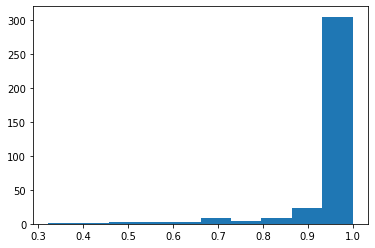

In [42]:
model_10 = CustomKNeighborsClassifier(n_neighbors=10, weights='distance')
model_10.fit(X_train, y_train)
out_probs_10 = model_10.predict_proba(X_test)
plt.hist(out_probs_10.max(axis=1))

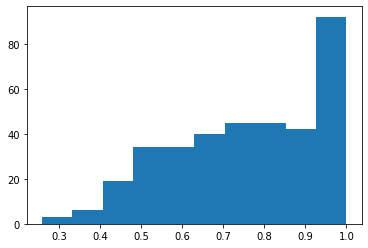

In [43]:
model_100 = CustomKNeighborsClassifier(n_neighbors=100, weights='distance')
model_100.fit(X_train, y_train)
out_probs_100 = model_100.predict_proba(X_test)
plt.hist(out_probs_100.max(axis=1));

It's not easy to find k-value. If we take small k, we can pay attintion to noise points. If we take big k, we can straight our results. Usually odd number is taken as k in order to have one class with max points into

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

c:\users\andrei shchahlou\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


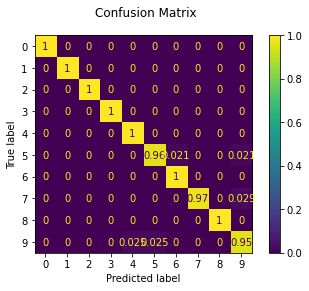

(0.9895615866388309, 0.9861111111111112)

In [44]:
## your code
model_uniform = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
# model_uniform.fit(X_train, y_train)
train_acc_uniform, test_acc_uniform = fit_evaluate(model_uniform, X_train, y_train, X_test, y_test)
train_acc_uniform, test_acc_uniform

With uniform weighting, we do not take into account the distance between the new data point and its k nearest neighbors. They all have equal influence over the prediction. With inverse distance weighting, we assign higher weights to the closer training examples.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Besides euclidian distance we can use mahalanobis, manhattan or minkowski distances. 

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

If we have sufficient computing resources to speedily handle the data you are using to make predictions, KNN can still be useful in solving problems that have solutions that depend on identifying similar objects. An example of this is using the KNN algorithm in recommender systems, an application of KNN-search. Sometimes It can be used for classification tasks

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [45]:
PATH = "./data/"

In [46]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [47]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [48]:
import seaborn as sns

### EDA

<AxesSubplot:xlabel='Survived', ylabel='count'>

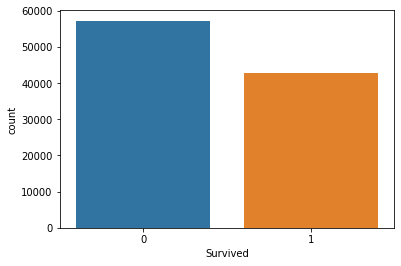

In [49]:
sns.countplot(x='Survived', data=data)

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [50]:
data.Sex.value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='count'>

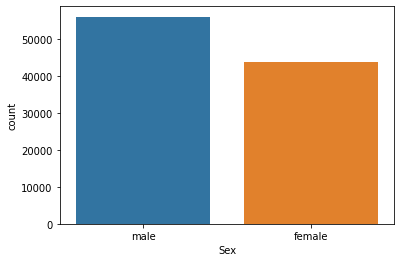

In [51]:
sns.countplot(x='Sex', data=data)

In [52]:
data.groupby('Sex')['Survived'].value_counts()

Sex     Survived
female  1           31226
        0           12660
male    0           44566
        1           11548
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

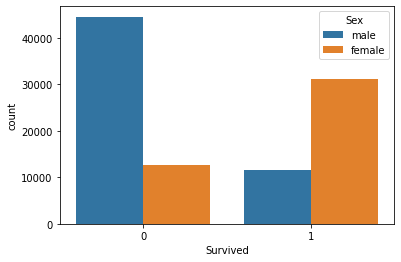

In [53]:
sns.countplot(x='Survived', hue='Sex', data=data)

I think we have relationship between gender and survival. Men tried to survive women and allowed them to sit into boats. One more reason - workers (or sailors) on Titanic were men. As we know a lot of workers were died. So, women survived more than men.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:xlabel='Age', ylabel='Count'>

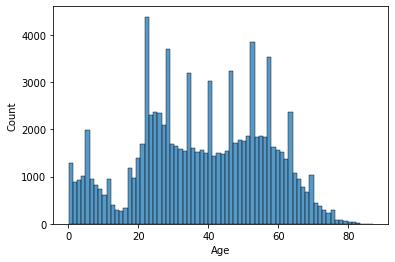

In [54]:
sns.histplot(data['Age'])

I can see from this histogram that many children is below 5 years old. Some of them are babies which we see that there's a peak around 1 year. This histogram doesn't have a normal distribution due to some peaks.

In [55]:
data.query('Survived == 0')['Age'].median()

36.0

In [56]:
data.query('Survived == 0')['Age'].mean()

36.70869488153374

<AxesSubplot:xlabel='Age', ylabel='Count'>

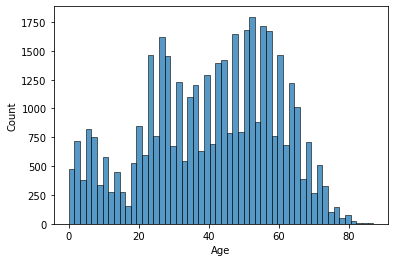

In [57]:
sns.histplot(data.query('Survived == 1')['Age'])

<AxesSubplot:xlabel='Age', ylabel='Count'>

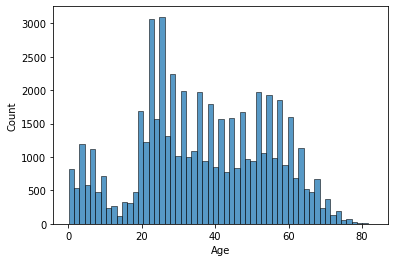

In [58]:
sns.histplot(data.query('Survived == 0')['Age'])

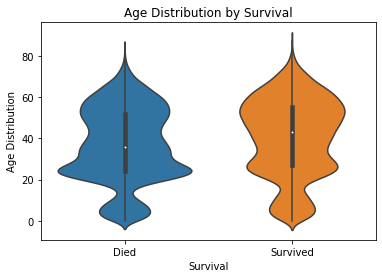

In [59]:
p = sns.violinplot(data = data, x = 'Survived', y = 'Age')
p.set(title = 'Age Distribution by Survival', 
        xlabel = 'Survival', 
        ylabel = 'Age Distribution', 
        xticklabels = ['Died', 'Survived']);

So from the above plot we can understand that, some of the older people died (between 50-70) and some of the younger people (between 20-40) survived more.
The distribution of the age shows bimodal distribution of people who survived. Many old people died, though we see more than 80 year-old man survived.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

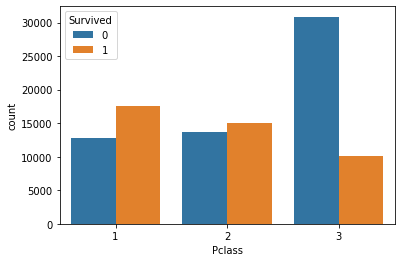

In [60]:
sns.countplot(x='Pclass',hue='Survived',data=data)

<AxesSubplot:xlabel='Survived', ylabel='count'>

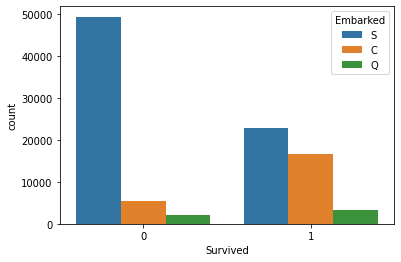

In [61]:
sns.countplot(x='Survived',hue='Embarked',data=data)

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

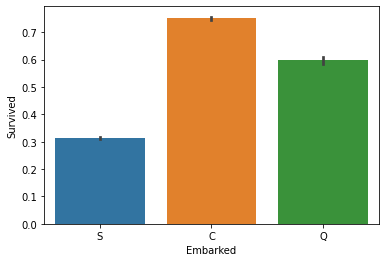

In [62]:
sns.barplot(x='Embarked',y='Survived',data=data)

From the plots above, we can see that passengers in the third class were far less likely to survive than passengers in the first and second class.
And we can see that people from Port of Embarkation = "C" (Cherbourg) were far more likely to survive.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [63]:
round((data.isnull().sum()*100)/len(data),2)

Survived     0.00
Pclass       0.00
Name         0.00
Sex          0.00
Age          3.29
SibSp        0.00
Parch        0.00
Ticket       4.62
Fare         0.13
Cabin       67.87
Embarked     0.25
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

- Cabin attribute has too much missing values, so I'll drop it in the first attempt.  
- Embarked attribute I can analyze due to values balance. And maybe put the value of attribute with the lowest total value. Or maybe analyze the target values due to rows with missing values and put the value according to probability of survation for the Embarked values. E.g., if Embarked value "C" has the most probability of survation and rows with missing values equals to Survived = 1, so put value "C" for all missing values.  
- I don't know how to fill Age missing values in a right way. Initially, I think I'll put median value due to no clear correlation between survival and the age of a person on the Titanic and that median value for survived and not survived is the same. So, if we put median value we won't increase significance of some class.  
- Fare I'll fill with median value.  
- Ticket can be filled by Fare values

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [64]:
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))

In [65]:
y_train = train_data['Survived']

For the first attempt let's drop Survived (it's the target), PassengerId (no useful information for us), Cabin (a lot of missing values), PassengerID, Name and Ticket columns.
Both Sex and Embarked columns let's convert to numeric.

In [66]:
X_train = train_data.drop(['Survived', 'PassengerId', 'Cabin', 'Name', 'Ticket'], axis=1)

In [67]:
X_train['Sex'] = X_train['Sex'].map({'female': 1, 'male': 0}).astype(int)

In [68]:
X_train['Embarked'] = X_train['Embarked'].fillna('C')

In [69]:
X_train['Embarked'] = X_train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [70]:
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())

In [71]:
X_train['Fare'] = X_train['Fare'].fillna(X_train['Fare'].median())

In [72]:
X_train.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [74]:
lr = LogisticRegression(C=0.05, max_iter=10000, random_state=42)
knn = KNeighborsClassifier()
scaler = StandardScaler()

In [77]:
models_accuracy = []

# Without feature scaling, logistic regression
models_accuracy.append(cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=5).mean())

# Without feature scaling, knn
models_accuracy.append(cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5).mean())

#With scaling StandardScaler + LogisticRegression
model_scaling = make_pipeline(StandardScaler(), lr)
models_accuracy.append(cross_val_score(model_scaling, X_train, y_train, scoring='accuracy', cv=5).mean())

#With scaling StandardScaler + Knn
model_scaling_knn = make_pipeline(StandardScaler(), knn)
models_accuracy.append(cross_val_score(model_scaling_knn, X_train, y_train, scoring='accuracy', cv=5).mean())

In [78]:
accuracy_df = pd.DataFrame({'Accuracy': models_accuracy}, index = ['LogisticRegression', 'KNN', 
                                                             'StandardScaler + LogisticRegression',
                                                             'StandardScaler + KNN'
                                                            ])
accuracy_df

,Accuracy
LogisticRegression,0.75825
KNN,0.72188
StandardScaler + LogisticRegression,0.75820
StandardScaler + KNN,0.74166


So, LogisticRegression gives us the better result. Let's try

In [79]:
def make_submission(df, pred, n):
    '''
    Create submission file
    :param df: test dataframe
    :param pred: predictions
    :n: numner of the file
    :returns: submission file in the appropriate format
    '''
    submission = pd.DataFrame({
            "PassengerId": df["PassengerId"],
            "Survived": pred
        })

    submission.to_csv('submission_titanic_{}.csv'.format(n), index=False)

In [80]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [81]:
X_test = test_data.drop(['PassengerId', 'Cabin', 'Name', 'Ticket'], axis=1)
X_test['Sex'] = X_test['Sex'].map({'female': 1, 'male': 0}).astype(int)
X_test['Embarked'] = X_test['Embarked'].fillna('C')
X_test['Embarked'] = X_test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].median())

In [82]:
X_test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [83]:
model_scaling.fit(X_train, y_train)
y_pred_lr = model_scaling.predict(X_test)
make_submission(test_data, y_pred_lr, '01')

Score: 0.79419 on Private LB. And 0.79813 on Public LB  
Let's try to improve it

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

<AxesSubplot:>

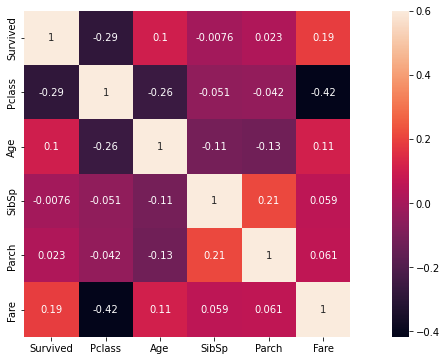

In [84]:
plt.figure(figsize=(15,6))
sns.heatmap(data.corr(), vmax=0.6, square=True, annot=True)

Some features are categorical, so we can't see them into correlation matrix.
Let's upload datasets one more time and start our work from scratch

In [190]:
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

All feature transformations I'm going to do on the both datasets.
Initially, let's transform 'Sex' feature from categorical to numeric cause we saw that women survived more than men previously on plots. So, this feature could be important for the model.

In [191]:
train_test_data = [train_data, test_data]

In [192]:
for data in train_test_data:
    data['Sex'] = data['Sex'].map({'female': 1, 'male': 0}).astype(int)

As we can see in correlation matrix, 'Pclass' feature has a negative strong correlation with target, but as we saw on plots, this feature will influence on target.
So, let's put it as is.

Then let's work with 'Age' feature.
We saw on plots that there is a correlation between person's age and survival, not great but it could help.
Let's fill empty values with median and split persons due to some ages:

In [193]:
for data in train_test_data:    
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data.loc[data['Age'] < 1, 'Age'] = 1
    data.loc[data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age'] = 4

The next one is 'Embarked'. Let's fill the empty value with 'S' and convert the feature to numeric format.

In [194]:
for data in train_test_data:
    data['Embarked'] = data['Embarked'].fillna('S')
    data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

Both 'Sibsp' and 'Parch' features a low correlation with target feature. Let's try to combine them into something more powerfull by creating a new feature and analyze it.

In [195]:
for data in train_test_data:
    data['Family'] = data['SibSp'] + data['Parch']

In [196]:
pd.crosstab(train_data['Family'], train_data['Survived'])

Survived,0,1
Family,,
0,36840,25013
1,6875,7337
2,5584,5205
3,5205,3605
4,1243,627
5,713,561
6,336,162
7,76,28
8,83,28


<AxesSubplot:xlabel='Family', ylabel='Survived'>

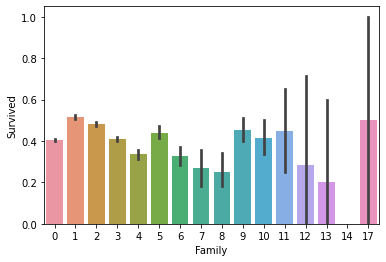

In [197]:
sns.barplot(x='Family',y='Survived',data=train_data)

As we can see, single persons and large families were far less likely to survive than passengers with not large family. let's transform this feature to another one - 'Alone'.

In [198]:
# for data in train_test_data:
#     data['Alone'] = 0
#     data.loc[data['Family'] == 1, 'Alone'] = 1

Initially we deleted 'Cabin' feature. Now we can try to interpret it. Cabin includes Deck number. Let's get it.

In [199]:
for data in train_test_data:
    data["Deck"]=data.Cabin.str[0]

In [200]:
train_data['Deck'].unique()

array(['C', nan, 'A', 'D', 'B', 'E', 'F', 'G', 'T'], dtype=object)

In [201]:
test_data['Deck'].unique()

array([nan, 'B', 'A', 'C', 'F', 'E', 'D', 'G', 'T'], dtype=object)

Let's fill empty values with some char, e.g. 'Y'.

In [202]:
for data in train_test_data:
    data['Deck'] = data['Deck'].fillna('Y')

In [203]:
pd.crosstab(train_data['Deck'], train_data['Survived'])

Survived,0,1
Deck,,
A,4575,1732
B,2751,4688
C,3403,8422
D,974,2663
E,669,1080
F,108,555
G,79,403
T,18,14
Y,44649,23217


Persons on decks 'B', 'C', 'D', 'E', 'F', 'G' were more likely to survive. Let's convert this feature to the numeric format according to this knowledge.
Honestly, we don't know about test data. And we can't say for 100% that it's the same for test_data.

In [204]:
deck = {'Y':0, 'T':0, 'G':1, 'F':1, 'E':1, 'D':1, 'C':1, 'B':1, 'A':0}
for data in train_test_data:
    data['Deck'] = data['Deck'].map(deck).astype(int)

Finally, let's finish EDA with 'Fare' feature

In [205]:
for data in train_test_data:
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [206]:
for col in ['Fare', 'Family', 'Parch', 'SibSp']:
    train_data[col] = np.log2(1 + train_data[col])
    test_data[col] = np.log2(1 + test_data[col])

<AxesSubplot:>

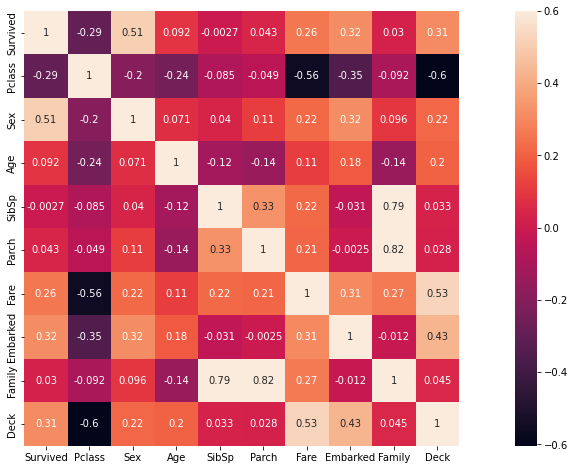

In [207]:
plt.figure(figsize=(20,8))
sns.heatmap(train_data.drop(['PassengerId'], axis=1).corr(), vmax=0.6, square=True, annot=True)

In [208]:
X_train = train_data.drop(['Survived',
                           'PassengerId',
                           'Name', 
                           'Ticket', 
                           'Cabin', 
                           # 'SibSp', 
                           # 'Parch', 
                           # 'Family'
                          ], axis=1)
y_train = train_data['Survived']
X_test = test_data.drop(['PassengerId', 
                         'Name',
                         'Ticket', 
                         'Cabin',
                         # 'SibSp', 
                         # 'Parch', 
                         # 'Family'
                        ], axis=1)

In [209]:
from sklearn.model_selection import KFold, StratifiedKFold

In [210]:
lr = LogisticRegression(C=0.05, max_iter=1000, random_state=7575)
# knn = KNeighborsClassifier(n_neighbors=55)
scaler = StandardScaler()
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7575)

In [211]:
models_accuracy = []

# Without feature scaling, original model
models_accuracy.append(cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

#With scaling StandardScaler + LogisticRegression
model_scaling = make_pipeline(StandardScaler(), lr)
models_accuracy.append(cross_val_score(model_scaling, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

# Without feature scaling, original model
# models_accuracy.append(cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

#With scaling StandardScaler + Knn
# model_scaling_knn = make_pipeline(StandardScaler(), knn)
# models_accuracy.append(cross_val_score(model_scaling_knn, X_train, y_train, scoring='accuracy', cv=k_fold).mean())

models_accuracy

[0.76334, 0.7633]

In [212]:
accuracy_df = pd.DataFrame({'Accuracy': models_accuracy}, 
                           index = ['LogisticRegression', 'StandardScaler+LogisticRegression'])
accuracy_df

,Accuracy
LogisticRegression,0.76334
StandardScaler+LogisticRegression,0.76330


In [213]:
model_scaling.fit(X_train, y_train)
y_pred_scale = model_scaling.predict(X_test)
make_submission(test_data, y_pred_scale, 'x14')

In [214]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
make_submission(test_data, y_pred, 'x15')

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

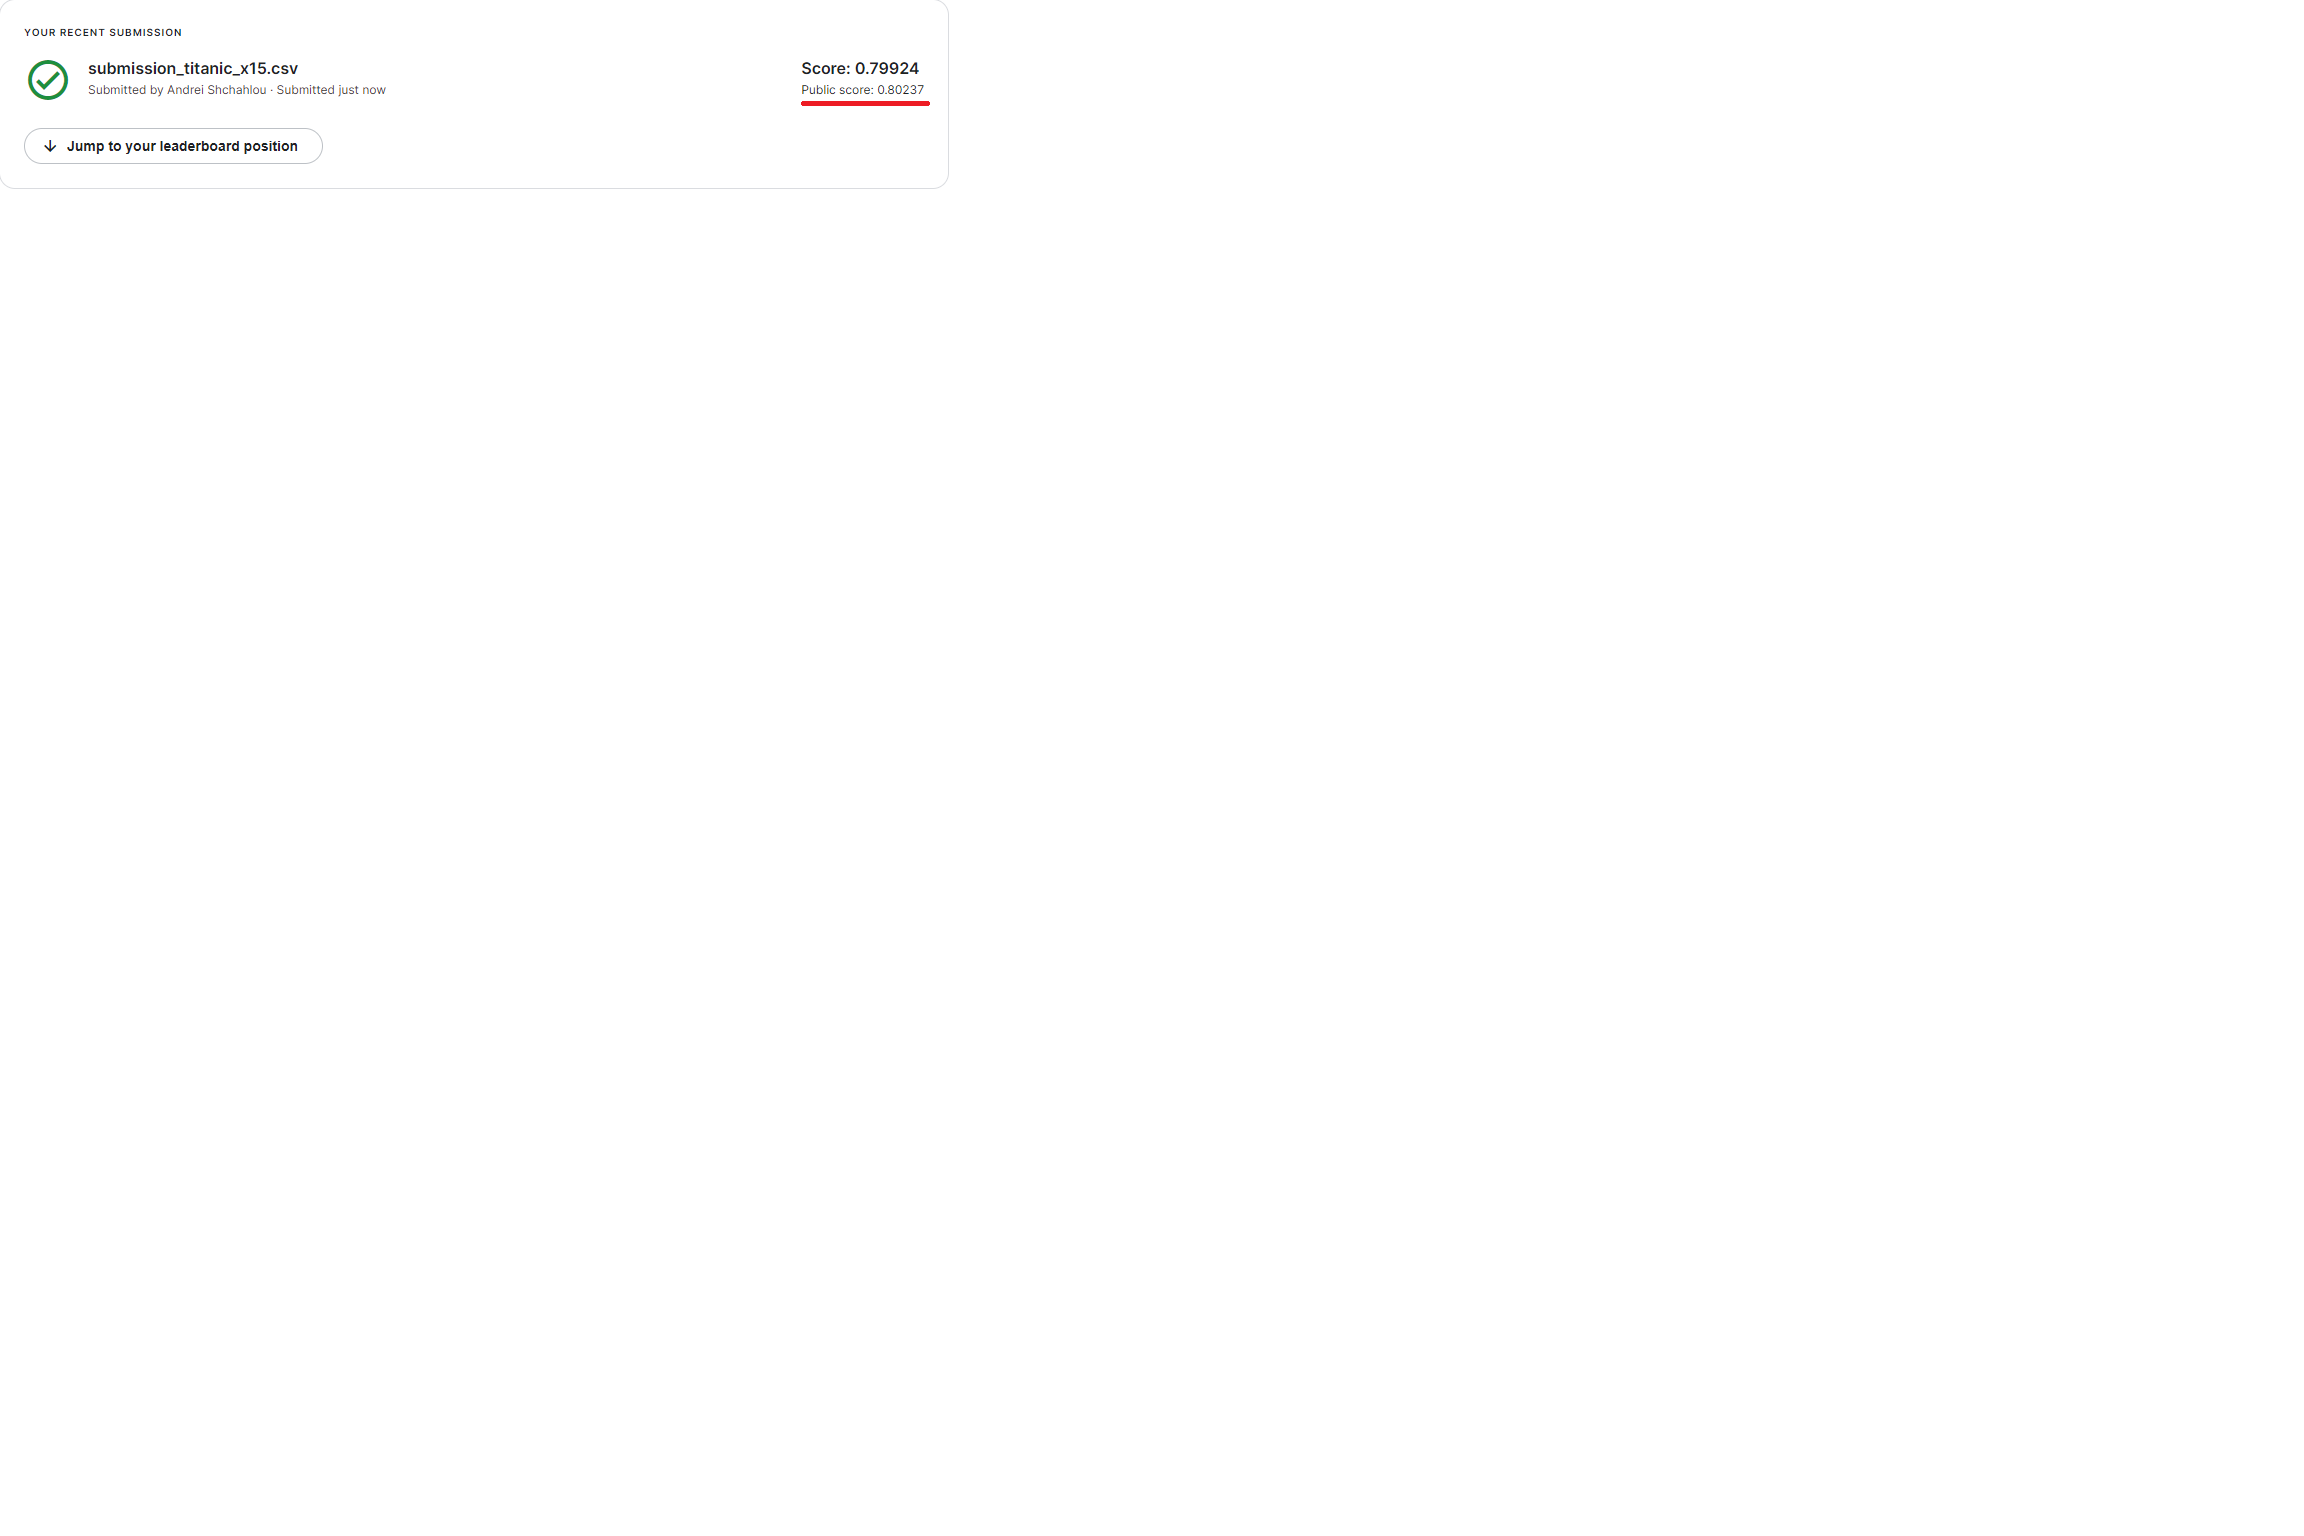

In [216]:
from IPython.display import Image
Image("submission.png")